In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8,6

import time
import os
import psycopg2

import os, sys
sys.path.append('C:/users/mohdh/Documents/MSBA/python modules/')
import regression
module_path = os.path.abspath(os.path.join('../../MSBA/time_series_20191113/modules/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import testing

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8,6

#### Testing for connection

Run the cell below to test if your machine is able to connect to the sanjose database.

If connection is successful, the expected output should be:<br>
`
Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 10.10 (Ubuntu 10.10-0ubuntu0.18.04.1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0, 64-bit',)
Database connection closed.
`

In [ ]:
conn = psycopg2.connect(host="sanjose",
                        database="atlas",
                        user="student"
                       )
 
def connect():
    '''
    Connect to the PostgreSQL database server
    '''
    #conn = None
    try:
        # read connection parameters
        #params = config()
 
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        #conn = psycopg2.connect(**params)
      
        # create a cursor
        cur = conn.cursor()
        
   # execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')
 
        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
       # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
 
 
if __name__ == '__main__':
    connect()

### Define Create Connection function

In [3]:
'''
arg should ideally be a config() file.
'''
def create_connection():
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    import psycopg2
    conn = None
    try:
        conn = psycopg2.connect(host="sanjose",
                        database="atlas",
                        user="student"
                       )
        if conn != None:
            print('Connection to database successful.')
        return conn
    except:
        logging.warning('unable to connect to database')
        exit(1)
 
    return conn


In [ ]:
conn = create_connection()
df = pd.read_sql_query('''SELECT region, 
                                    CONCAT(CONCAT(EXTRACT(YEAR from date),'-',EXTRACT(MONTH from date)),'-','01') as timestamp,
                                    MAX(min_temp) as max_temp
                           FROM student_weather 
                           GROUP BY region, CONCAT(CONCAT(EXTRACT(YEAR from date),'-',EXTRACT(MONTH from date)),'-','01')
                           LIMIT 20000;
                       ''', 
                      conn)
if conn is not None:
    conn.close()

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
df.sort_values(by=['region','timestamp'],inplace=True)

In [ ]:
df.pivot(index='timestamp',
         columns='region',
         values='max_temp')

In [ ]:
for i in df['region'].unique():
    plt.plot(df[(df['region'] == i) & (df['timestamp'] > '2000-01-01')]['timestamp'],
             df[(df['region'] == i) & (df['timestamp'] > '2000-01-01')]['max_temp'],
             label = i)
    
plt.legend(loc='upper right')
plt.title('Monthly maximum min temperatures\n2000-2018')
plt.show()

## START HERE

Below, we extract a dataset containing average measurements across regions and months

In [4]:
# Create connection
conn = create_connection()
# The SQL query
df = pd.read_sql_query('''SELECT region, EXTRACT(YEAR FROM date) AS year, 
                              EXTRACT(MONTH FROM date) AS month, MAX(min_temp) as min_temp,
                              MAX(precipitation) as precip, MAX(wind) as wind
                          FROM student_weather 
                          GROUP BY 1,2,3;
                       ''', 
                      conn)
# Closes connection if it exists
if conn is not None:
    conn.close()

Connection to database successful.


In [50]:
# Create connection
conn = create_connection()
# The SQL query
df = pd.read_sql_query('''SELECT EXTRACT(YEAR FROM date) AS year, 
                              EXTRACT(MONTH FROM date) AS month, MAX(min_temp) as min_temp,
                              MAX(precipitation) as precip, MAX(wind) as wind
                          FROM student_weather 
                          GROUP BY 1,2,3;
                       ''', 
                      conn)
# Closes connection if it exists
if conn is not None:
    conn.close()

Connection to database successful.


DatabaseError: Execution failed on sql 'SELECT EXTRACT(YEAR FROM date) AS year, 
                              EXTRACT(MONTH FROM date) AS month, AVG(MAX(min_temp)) as mean_temp,
                              MAX(precipitation) as precip, MAX(wind) as wind
                          FROM student_weather 
                          GROUP BY 1,2,3;
                       ': aggregate function calls cannot be nested
LINE 2: ...           EXTRACT(MONTH FROM date) AS month, AVG(MAX(min_te...
                                                             ^


In [5]:
'''
args: pandas row

This function concatenates the year and month of a time series
record into a pandas datetime object.

returns:
'''
def combine_yr_mth(x):
    s = '-'  # delimiter of choice
    year = str(int(x['year']))
    month = str(int(x['month']))
    # If month is single digit, adds a '0' prefix
    if len(month) < 2:
        month = '0' + month
    # Temporary list. Uses .join() function to concatenate    
    date = [year,month,'01']
    timestamp = s.join(date)
    
    return timestamp

In [6]:
# Create a timestamp column to be used as the index
df['timestamp'] = pd.to_datetime(df.apply(lambda x : combine_yr_mth(x), axis=1))
nat = pd.DataFrame(df.groupby(['timestamp'])['min_temp','precip','wind'].mean())

In [7]:
# Print first and last 5 rows
print('First 5 rows:\n')
print(nat.head(5))
print('\nLast 5 rows:\n')
print(nat.tail(5))

First 5 rows:

             min_temp      precip      wind
timestamp                                  
1949-01-01   5.793571  348.745000  5.673571
1949-02-01   7.385714  335.567857  5.561429
1949-03-01  10.055000  293.986429  5.741429
1949-04-01  13.618571  221.721429  5.215000
1949-05-01  18.296429  272.618571  4.499286

Last 5 rows:

             min_temp      precip      wind
timestamp                                  
2010-08-01  24.751429  256.639286  3.824286
2010-09-01  20.384286  307.145714  4.494286
2010-10-01  14.180000  254.367143  4.900714
2010-11-01  10.259286  271.164286  5.655714
2010-12-01   5.780714  388.582857  6.205714


#### Seasonal decomposition

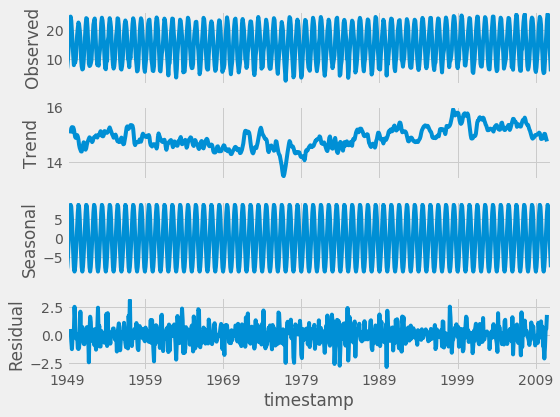

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(nat['min_temp'], model='add')
res.plot()
del res

plt.show()

- The trend component seems pretty interesting. It looks like the variance is getting bigger over time, and it takes longer to move the other way.
- Resiaulds don't really appear to be normal - requires further diagnostics.

#### Time Series Analysis of Raw Data

ADF Statistic: -4.380280
p-value: 0.000322
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569

We reject the Null Hypothesis (H0) -- the time series is stationary


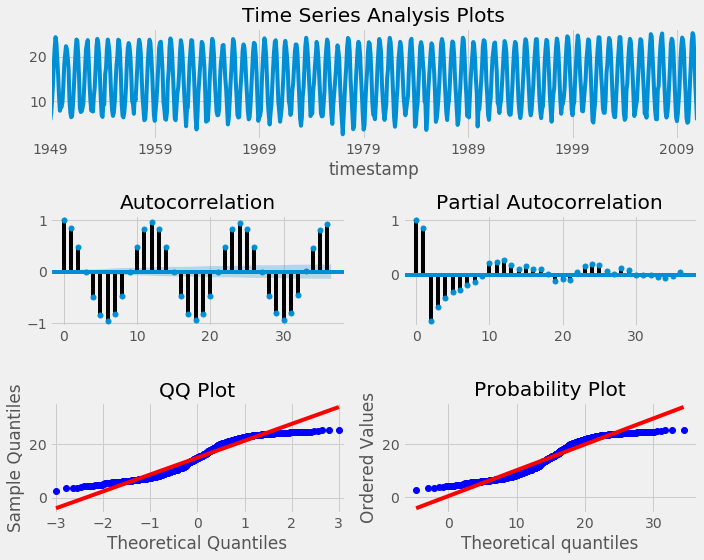

In [9]:
testing.ts_plot(nat['min_temp'],lags=36,style='fivethirtyeight')

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox
lb, p_values = ljungbox(nat['min_temp'],
                        lags = 24)

p_values

array([4.29089428e-119, 8.72153712e-156, 1.84541759e-154, 5.43025455e-192,
       5.27911520e-305, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

- ADF stat indicates the time series is stationary
- PACF plot indicates some serial autocorrelation exists.
- significant p-vals of Ljung-Box test indiciates serial autocorrelation.

#### OLS Model

Since the data is obviously seasonal, we will introduce a Fourier series to captu

In [29]:
# Enumerates the index in the time series and calculates the FFT based
#   off the index number. Returns a list
X_f = []
for n, a in enumerate(nat.index):
    x = [1, n, np.sin(2 * n * np.pi / 12), np.cos(2 * n * np.pi / 12)]
    X_f += [x]

# Convert the list created into a pandas DF, using the initial time series index
X_f = pd.DataFrame(X_f, columns=['Const', 'Idx', 'Sin', 'Cos'], index=nat.index)

# Concatenate the FFT with the initial endog. time series
nat_f = pd.concat([nat, X_f],axis=1)
# Delete the FFT to save memory
del X_f

Introducing lag 1, lag 2, lag 6, lag 12, lag 24

In [30]:
nat_f['L_1'] = pd.DataFrame(nat_f['min_temp']).shift(1)
nat_f['L_2'] = pd.DataFrame(nat_f['min_temp']).shift(2)
nat_f['L_6'] = pd.DataFrame(nat_f['min_temp']).shift(6)
nat_f['L_12'] = pd.DataFrame(nat_f['min_temp']).shift(12)
nat_f['L_24'] = pd.DataFrame(nat_f['min_temp']).shift(24)

In [32]:
from sklearn.model_selection import train_test_split

y = list(nat_f['min_temp'])
X = nat_f.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False)

In [ ]:
import statsmodels.api as sm # Time Series Analysis

reg = sm.OLS(y_train[24:],
             X_train[24:])
results = reg.fit()
results.summary()

In [ ]:
testing.ts_plot(results.resid, lags=24)

In [ ]:
idx = list(range(len(y_train[24:])))
y_hat = results.predict(X_train[24:])

print('---------------\n%s\n---------------' % ('Monthly Min Temp\nFourier Series, Lag 24'))
testing.eval_plot(idx, y_train[24:], y_hat)

In [ ]:
perf_in = {}
perf_in['national_L24'] = testing.measure_error(y_train[24:], y_hat, label='Fourier Series L_24 Regressors')

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sdev_ols_l24, lower_pred_ols_l24, upper_pred_ols_l24 = wls_prediction_std(results, exog=np.array(X_test.values))

In [ ]:
Y_pred = results.predict(X_test)

plt.plot(list(nat_f[24:len(y_train)].index), y_hat, label = 'y-hat in sample')
plt.plot(list(nat_f[24:len(y_train)].index), y_train[24:], label = 'y-actual in sample')
#plt.plot(list(nat_f[len(y_train):].index),Y_pred, label = 'y-hat OOS')
#plt.plot(list(nat_f[len(y_train):].index), y_test, label = 'y-actual OOS')
#plt.fill_between(list(nat_f[len(y_train):].index),
#                 lower_pred_ols_l24, upper_pred_ols_l24,
#                 alpha=0.2, color='g')
plt.title('Predicted vs Actual\nNational, monthly, Fourier FFT w/ Lag 24')
plt.legend()
plt.show()

AUTO ARIMA WITH FOURIER FFT

Splitting the data into train/test sets

In [ ]:
y = list(nat_f['min_temp'][24:])

y_train, y_test = train_test_split(y,
                                   test_size=0.2,
                                   random_state=42,
                                   shuffle=False)

Estimate D

In [ ]:
testing.ts_plot(y_train)

ADF stat at D = 0 is stationary, so differencing is not required

In [ ]:
from pmdarima.arima import auto_arima

sarima_model = auto_arima(y_train,
                           start_p=1,
                           start_q=1,
                           max_p=6,
                           max_q=6,
                           start_P=0,
                           start_Q=0,
                           max_P=3,
                           max_Q=3,
                           m=12, 
                           seasonal=True,
                           trace=True,
                           d=0,
                           D=0,
                           error_action='warn',
                           suppress_warnings=True,
                           random_state = 42,
                           n_fits=20
                         )

In [ ]:
sarima_model.order, sarima_model.seasonal_order
model_specs = 'SARIMA%sx%s' % (str(sarima_model.order), str(sarima_model.seasonal_order))
print(model_specs)

In [ ]:
sarima_model.summary()

#### ARCH model

We calculate variance for the dataset

In [33]:
nat['var'] = (nat['min_temp'] - np.mean(nat['min_temp']) ) ** 2
nat['err'] = nat['min_temp'] - np.mean(nat['min_temp']) 
nat.head(5)

,min_temp,precip,wind,var,err
timestamp,,,,,
1949-01-01,5.793571,348.745000,5.673571,82.326005,-9.073368
1949-02-01,7.385714,335.567857,5.561429,55.968728,-7.481225
1949-03-01,10.055000,293.986429,5.741429,23.154760,-4.811939
1949-04-01,13.618571,221.721429,5.215000,1.558422,-1.248368
1949-05-01,18.296429,272.618571,4.499286,11.761396,3.429489


We then split the data set into train and test sets

In [35]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(nat,
                                   test_size=0.2,
                                   shuffle=False,
                                   random_state=42)

ADF Statistic: -6.470619
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

We reject the Null Hypothesis (H0) -- the time series is stationary


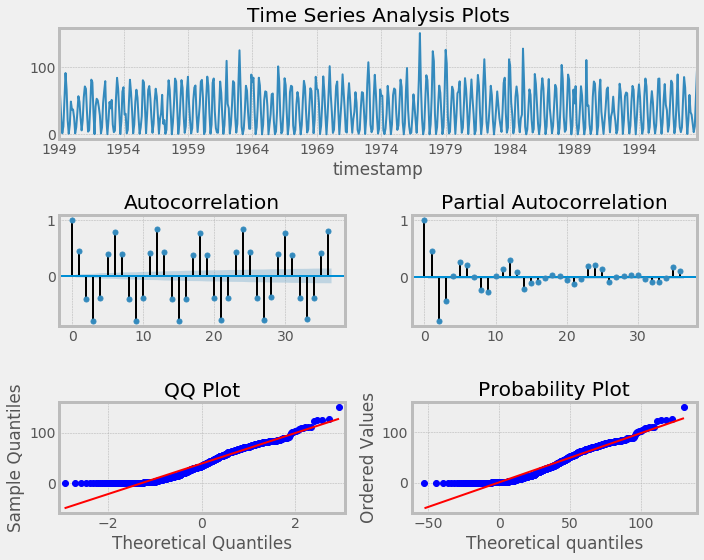

In [36]:
testing.ts_plot(y_train['var'],lags=36)

Ljung-Box diagnosis

In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox

lb, p_values=ljungbox(y_train['var'], lags=12)

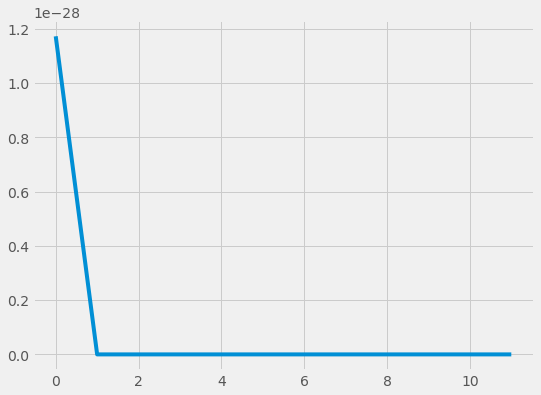

[1.17207286e-028 5.28304159e-049 8.61425474e-134 1.93305722e-153
 4.20451255e-173 2.94392632e-253 6.10036051e-272 1.53865378e-292
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


In [38]:
plt.plot(p_values)
plt.show()
print(p_values)

The low p-values of the Ljung-Box test suggest there is auto-correlation left in the residuals

### ARCH Forecast

In [45]:
from arch import arch_model

model = arch_model(y_train['min_temp'], mean='Constant', vol='ARCH',dist='gaussian',p=1)
f_arch = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1913.7213541150797
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1913.6497133116827
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1913.3716924067871
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1913.3695415865518
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1913.367732677542
Iteration:      6,   Func. Count:     34,   Neg. LLF: 1913.3663388417517
Iteration:      7,   Func. Count:     39,   Neg. LLF: 1913.366129413795
Iteration:      8,   Func. Count:     44,   Neg. LLF: 1913.366116954579
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1913.3661169546272
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


In [40]:
f_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:               min_temp   R-squared:                      -0.004
Mean Model:             Constant Mean   Adj. R-squared:                 -0.004
Vol Model:                       ARCH   Log-Likelihood:               -1913.37
Distribution:                  Normal   AIC:                           3832.73
Method:            Maximum Likelihood   BIC:                           3845.90
                                        No. Observations:                  595
Date:                Tue, Dec 03 2019   Df Residuals:                      592
Time:                        12:51:02   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            14.3448      1.023     14.022  1.141e-44 [ 12.340, 16.350]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         19.7437      1.871     10.555  4.832e-26 [ 16.077, 23.410]
alpha[1]       0.5014  5.296e-02      9.467  2.890e-21 [  0.398,  0.605]
========================================================================

Covariance estimator: robust
"""

### GARCH Model

In [47]:
model = arch_model(y_train['min_temp'], mean='Constant', vol='GARCH',dist='gaussian',p=3, q=2)
f_garch = model.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1934.2772602298196
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1934.2616990780348
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1933.774109474256
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1933.6033346464742
Iteration:      5,   Func. Count:     49,   Neg. LLF: 1933.0750665894557
Iteration:      6,   Func. Count:     58,   Neg. LLF: 1930.8061027013146
Iteration:      7,   Func. Count:     67,   Neg. LLF: 1913.8826862459882
Iteration:      8,   Func. Count:     78,   Neg. LLF: 1913.7875252042957
Iteration:      9,   Func. Count:     89,   Neg. LLF: 1913.4643021539064
Iteration:     10,   Func. Count:     98,   Neg. LLF: 1913.4322060833138
Iteration:     11,   Func. Count:    107,   Neg. LLF: 1913.3671464465529
Iteration:     12,   Func. Count:    116,   Neg. LLF: 1913.3661249554598
Iteration:     13,   Func. Count:    125,   Neg. LLF: 1913.3661178746997
Optimization terminated successfully.    (Exit mode 

In [48]:
f_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               min_temp   R-squared:                      -0.004
Mean Model:             Constant Mean   Adj. R-squared:                 -0.004
Vol Model:                      GARCH   Log-Likelihood:               -1913.37
Distribution:                  Normal   AIC:                           3840.73
Method:            Maximum Likelihood   BIC:                           3871.45
                                        No. Observations:                  595
Date:                Tue, Dec 03 2019   Df Residuals:                      588
Time:                        12:56:47   Df Model:                            7
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            14.3449      1.024     14.005  1.451e-44 [ 12.337, 16.352]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         19.7425      5.329      3.705  2.115e-04 [  9.298, 30.187]
alpha[1]       0.5014      0.136      3.681  2.327e-04 [  0.234,  0.768]
alpha[2]   2.4841e-10      0.142  1.754e-09      1.000 [ -0.278,  0.278]
alpha[3]   2.6253e-10      0.134  1.964e-09      1.000 [ -0.262,  0.262]
beta[1]    1.2469e-10  6.927e-02  1.800e-09      1.000 [ -0.136,  0.136]
beta[2]    1.3216e-10  7.671e-02  1.723e-09      1.000 [ -0.150,  0.150]
========================================================================

Covariance estimator: robust
"""

### EGARCH Model

In [49]:
model = arch_model(y_train['min_temp'], mean='Constant', vol='EGARCH',dist='gaussian', p=0, q=0, o=1)
e_garch = model.fit()
e_garch.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2947.570422212825
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2945.7545149802636
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2019.921629314765
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2007.7557767446006
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1957.8883804579968
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1940.7463524894515
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1933.8717934258775
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1933.5522908756566
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1933.5418530330044
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1933.5284742319184
Iteration:     11,   Func. Count:     62,   Neg. LLF: 1933.4677457505265
Iteration:     12,   Func. Count:     67,   Neg. LLF: 1933.257199683139
Iteration:     13,   Func. Count:     72,   Neg. LLF: 1928.8494065317682
Iteration:     14,   Func. Count:     80,   Neg. LLF: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EARCH Model Results                      
==============================================================================
Dep. Variable:               min_temp   R-squared:                      -0.409
Mean Model:             Constant Mean   Adj. R-squared:                 -0.409
Vol Model:                      EARCH   Log-Likelihood:               -1920.40
Distribution:                  Normal   AIC:                           3846.80
Method:            Maximum Likelihood   BIC:                           3859.97
                                        No. Observations:                  595
Date:                Tue, Dec 03 2019   Df Residuals:                      592
Time:                        12:57:26   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.7673      0.583     18.476  3.236e-76 [  9.625, 11.909]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.3279      0.112     29.780 7.025e-195 [  3.109,  3.547]
gamma[1]       0.9128      0.143      6.397  1.587e-10 [  0.633,  1.192]
========================================================================

Covariance estimator: robust
"""

Massive function to loop through each region. Can be used for different lat-long combos, and for ARCH modeling

---------------
Time Series Regression Results
ark
---------------
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              6246.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                        0.00
Time:                        12:07:35   Log-Likelihood:                         -1147.4
No. Observations:                 559   AIC:                                      2307.
Df Residuals:                     553   BIC:                                      2333.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t

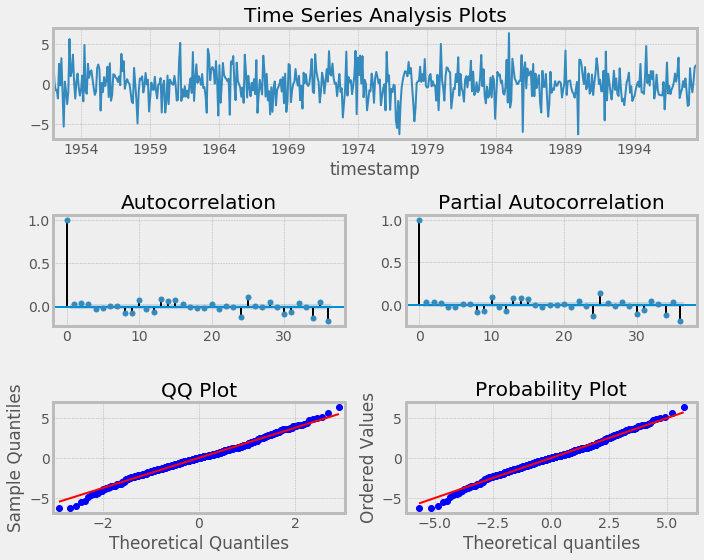

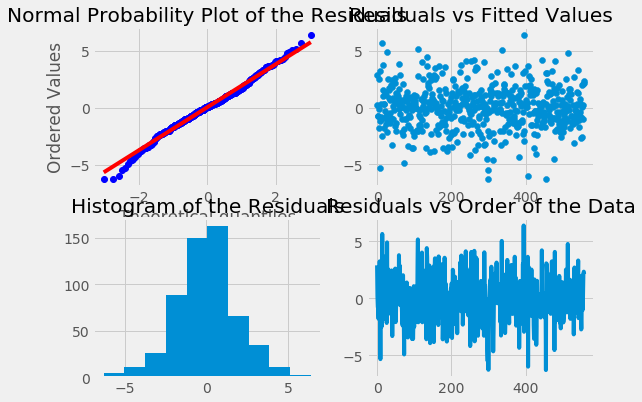

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.50052793 0.52466979 0.62220307 0.71700982 0.79636668 0.87981919
 0.93413167 0.65552345 0.46659797 0.25221993 0.28482927 0.21985522
 0.10036863 0.07076818 0.04387539 0.0545229  0.07509953 0.09826444
 0.12566333 0.14695409]
PROBLEM!  There appears to be information left in the residuals
+------------+------------------------------------+
|   metric   |               value                |
+------------+------------------------------------+
|   label    | ark Fourier Series L_24 Regressors |
|    RMSE    |         1.8844587865717473         |
| RMSE_pcent |        0.13612618229548448         |
+------------+------------------------------------+
+------------+----------------------------------------+
|   metric   |                 value                  |
+------------+---------

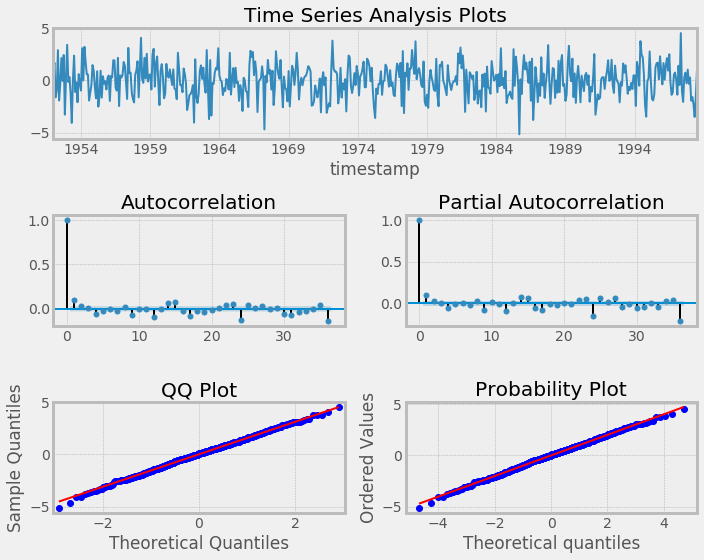

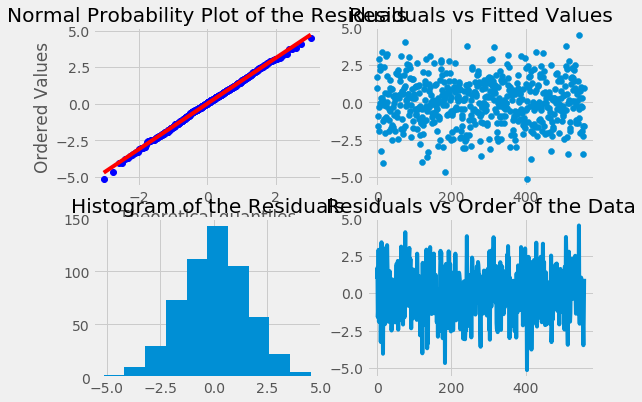

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.01454938 0.03474859 0.07906081 0.07181387 0.11290372 0.17735197
 0.23303615 0.28996312 0.17340192 0.23675256 0.30680442 0.13186909
 0.17741578 0.12964254 0.08477666 0.10879893 0.06381546 0.08119682
 0.09335057 0.11996191]
PROBLEM!  There appears to be information left in the residuals
+------------+-------------------------------------+
|   metric   |                value                |
+------------+-------------------------------------+
|   label    | cali Fourier Series L_24 Regressors |
|    RMSE    |          1.5499884039704221         |
| RMSE_pcent |         0.08734600221776186         |
+------------+-------------------------------------+
+------------+-----------------------------------------+
|   metric   |                  value                  |
+------------+

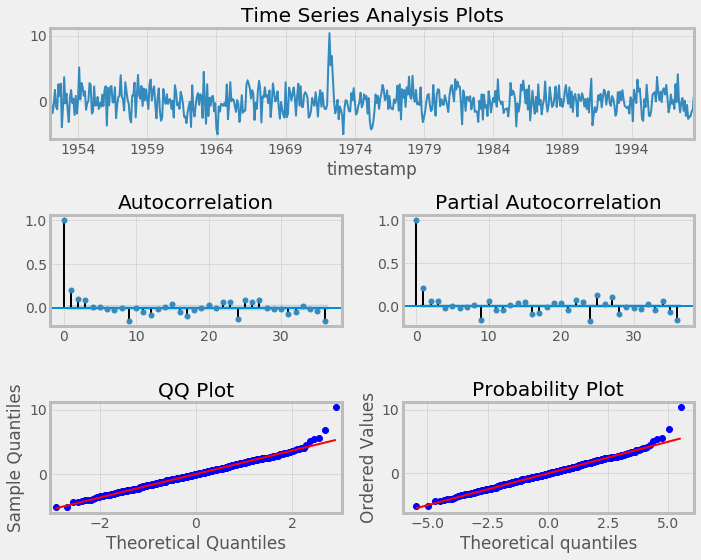

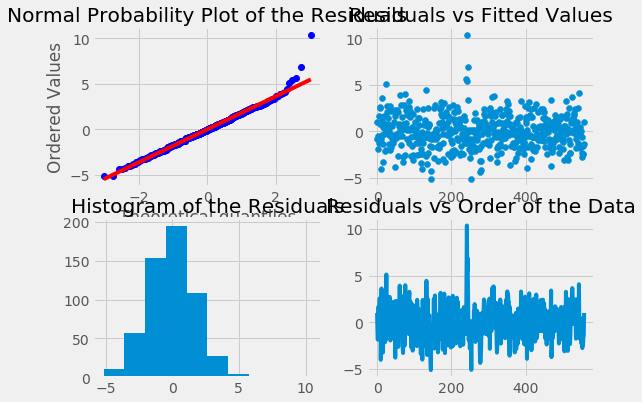

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [1.31918297e-06 4.33666716e-07 1.86097025e-07 6.83092393e-07
 2.13573802e-06 5.66296146e-06 1.28051117e-05 3.04802116e-05
 2.00280411e-07 4.88270472e-07 5.89667225e-07 2.86981792e-07
 6.03851382e-07 1.24835395e-06 1.73446412e-06 1.87294291e-06
 4.19883431e-07 7.51942592e-07 1.44584076e-06 2.09776103e-06]
PROBLEM!  There appears to be information left in the residuals
+------------+--------------------------------------+
|   metric   |                value                 |
+------------+--------------------------------------+
|   label    | color Fourier Series L_24 Regressors |
|    RMSE    |          1.8145842037819961          |
| RMSE_pcent |         0.10440527381564729          |
+------------+--------------------------------------+
+------------+--------------------------

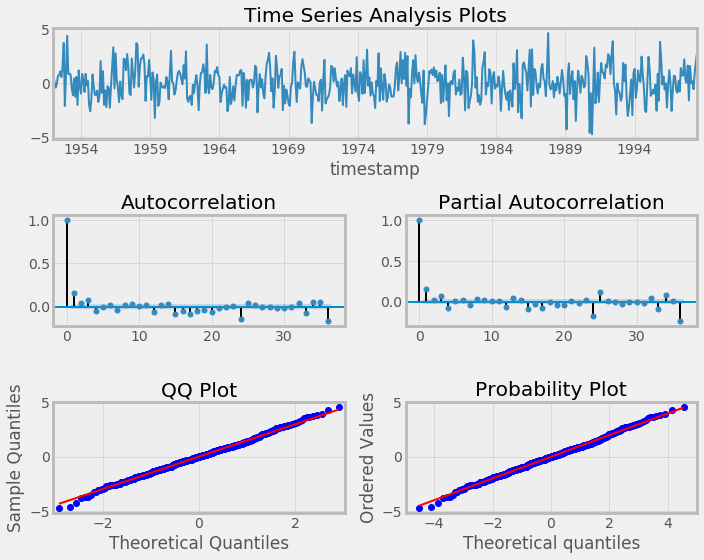

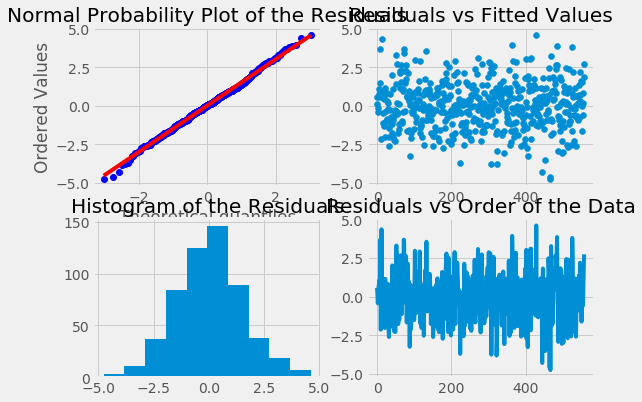

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.00015276 0.00044746 0.00030625 0.00040927 0.00102075 0.0020708
 0.00280197 0.00496169 0.00785629 0.01343277 0.02039586 0.01795718
 0.02655361 0.03370147 0.01372159 0.01401411 0.00609478 0.00565229
 0.00636068 0.00559337]
PROBLEM!  There appears to be information left in the residuals
+------------+------------------------------------+
|   metric   |               value                |
+------------+------------------------------------+
|   label    | crb Fourier Series L_24 Regressors |
|    RMSE    |         1.4980923239527557         |
| RMSE_pcent |        0.15552440656273847         |
+------------+------------------------------------+
+------------+----------------------------------------+
|   metric   |                 value                  |
+------------+----------

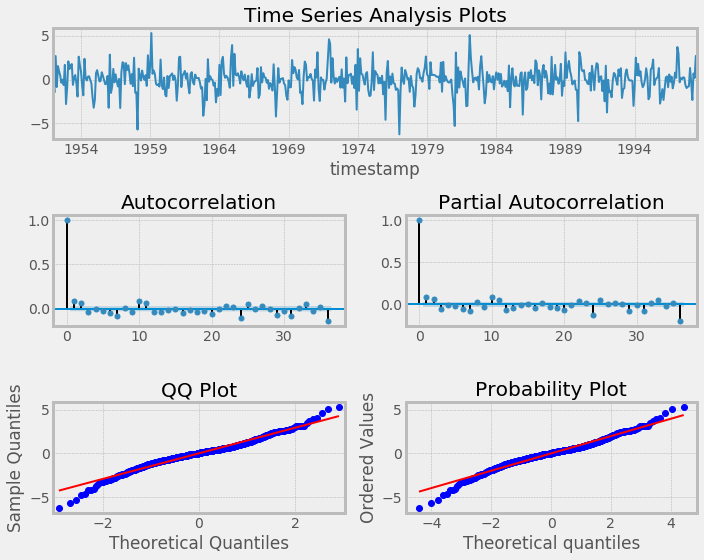

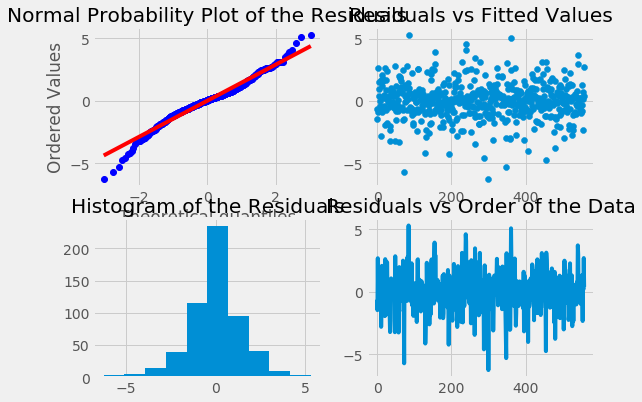

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.03248709 0.02682584 0.04245249 0.08374769 0.12427145 0.11862706
 0.04531374 0.07230731 0.09128404 0.03347824 0.02398951 0.02943732
 0.03349591 0.04640598 0.06584523 0.06583987 0.08668341 0.09998582
 0.11766402 0.09781879]
PROBLEM!  There appears to be information left in the residuals
+------------+-------------------------------------+
|   metric   |                value                |
+------------+-------------------------------------+
|   label    | east Fourier Series L_24 Regressors |
|    RMSE    |          1.4606874549681823         |
| RMSE_pcent |         0.06914230420584519         |
+------------+-------------------------------------+
+------------+-----------------------------------------+
|   metric   |                  value                  |
+------------+

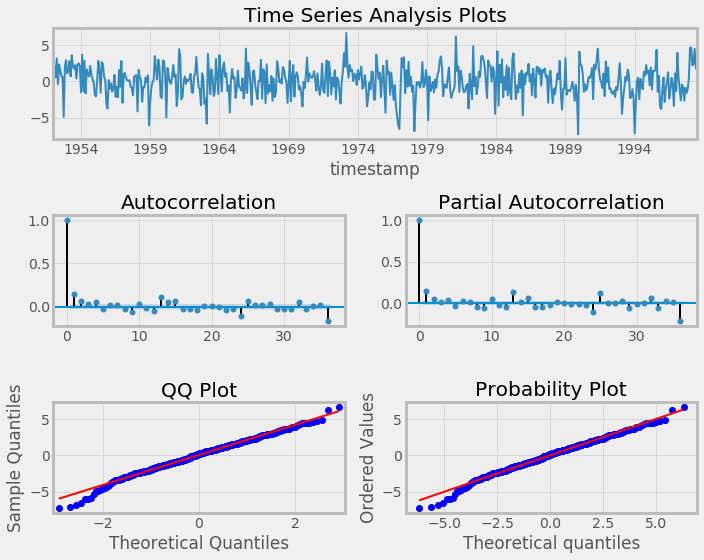

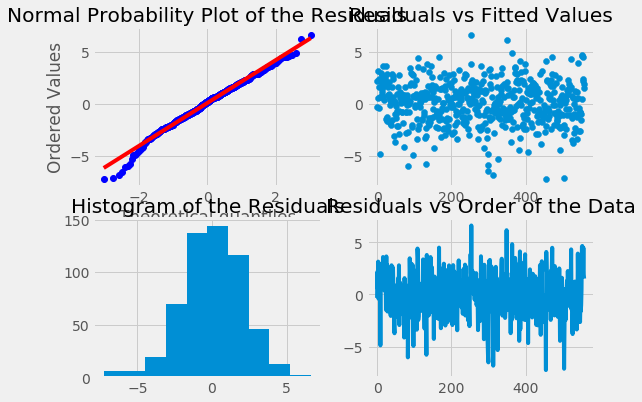

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.00046812 0.00065698 0.00169308 0.00228887 0.00460913 0.00832021
 0.01406421 0.02033008 0.01416668 0.02029655 0.02996893 0.0278549
 0.00442585 0.00454349 0.00331792 0.00456386 0.00630544 0.0078824
 0.01171256 0.0168869 ]
PROBLEM!  There appears to be information left in the residuals
+------------+---------------------------------------+
|   metric   |                 value                 |
+------------+---------------------------------------+
|   label    | glakes Fourier Series L_24 Regressors |
|    RMSE    |           2.0622614640213843          |
| RMSE_pcent |          0.30083144793869454          |
+------------+---------------------------------------+
+------------+-------------------------------------------+
|   metric   |                   value                   

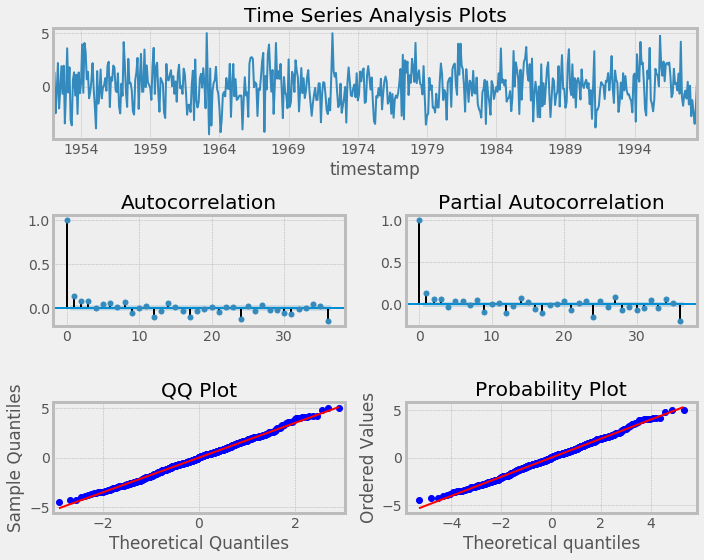

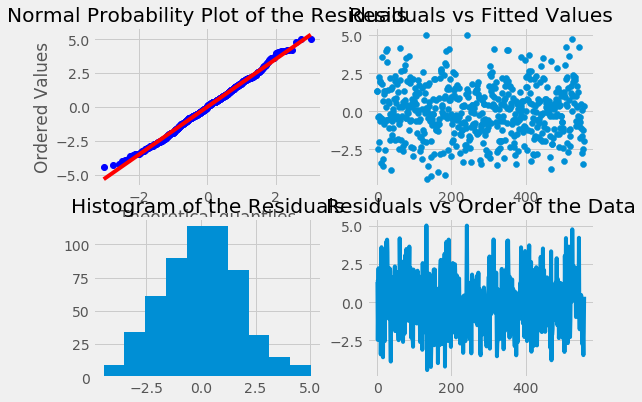

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.00185757 0.00141015 0.00069358 0.00188779 0.00259839 0.00282955
 0.00563719 0.00449965 0.00366782 0.00649682 0.01023427 0.0025387
 0.00335277 0.00337727 0.00533099 0.00706079 0.00146524 0.00178482
 0.00271069 0.00411501]
PROBLEM!  There appears to be information left in the residuals
+------------+------------------------------------+
|   metric   |               value                |
+------------+------------------------------------+
|   label    | grb Fourier Series L_24 Regressors |
|    RMSE    |         1.7547588183929956         |
| RMSE_pcent |        0.12656578920307662         |
+------------+------------------------------------+
+------------+----------------------------------------+
|   metric   |                 value                  |
+------------+----------

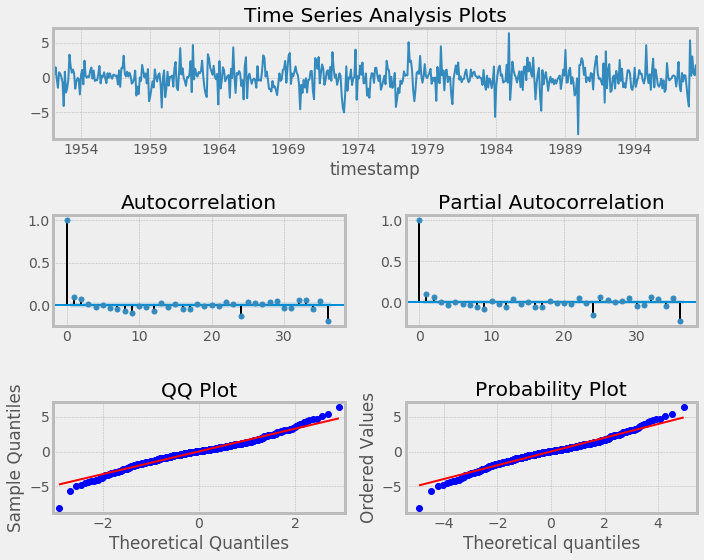

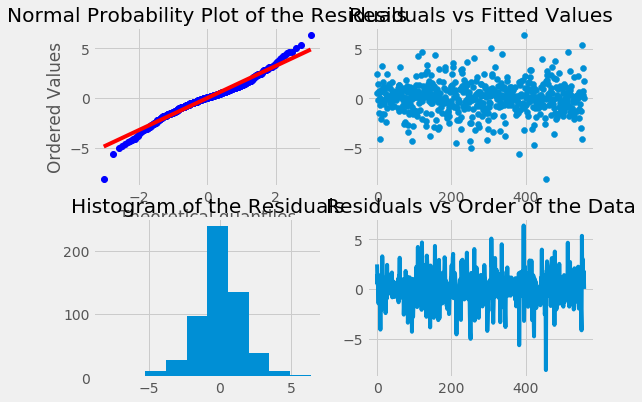

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.02462553 0.02173534 0.05138887 0.08420665 0.14429619 0.17570628
 0.1898172  0.12947387 0.03525688 0.05454787 0.07009384 0.0506413
 0.06724922 0.08726957 0.11679248 0.10970326 0.10113966 0.12948019
 0.16379472 0.20520472]
PROBLEM!  There appears to be information left in the residuals
+------------+-------------------------------------+
|   metric   |                value                |
+------------+-------------------------------------+
|   label    | gulf Fourier Series L_24 Regressors |
|    RMSE    |          1.6295251602348613         |
| RMSE_pcent |          0.0830681498822504         |
+------------+-------------------------------------+
+------------+-----------------------------------------+
|   metric   |                  value                  |
+------------+-

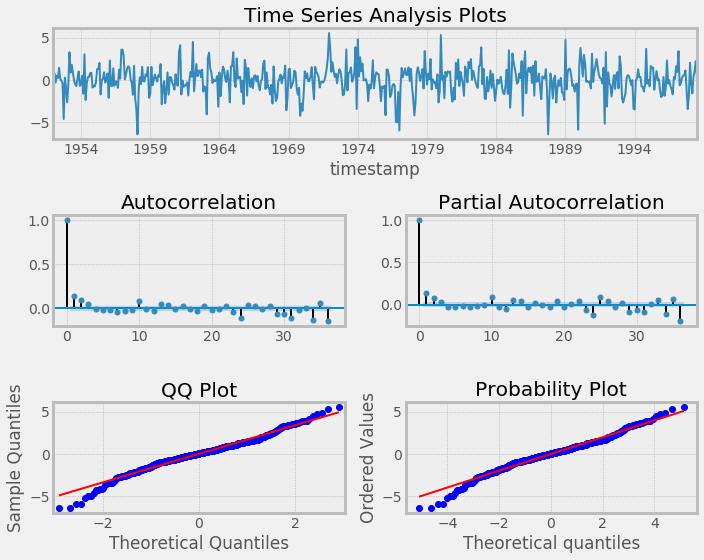

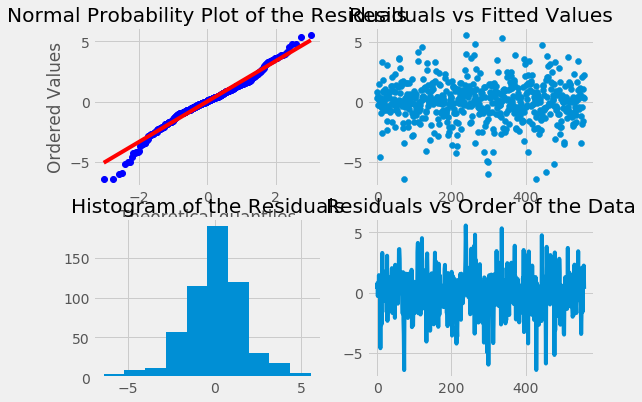

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.00097627 0.00024587 0.00042006 0.00117681 0.0024989  0.00476933
 0.0071201  0.01131061 0.01814346 0.00807258 0.01338904 0.01726775
 0.01744094 0.01912957 0.02829768 0.0367293  0.05167069 0.06057768
 0.07497655 0.09669647]
PROBLEM!  There appears to be information left in the residuals
+------------+------------------------------------+
|   metric   |               value                |
+------------+------------------------------------+
|   label    | low Fourier Series L_24 Regressors |
|    RMSE    |         1.6888463668262845         |
| RMSE_pcent |        0.09816087072833599         |
+------------+------------------------------------+
+------------+----------------------------------------+
|   metric   |                 value                  |
+------------+---------

C:\Users\mohdh\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


ADF Statistic: -10.412756
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570

We reject the Null Hypothesis (H0) -- the time series is stationary
---------------
Monthly Min Temp
Fourier Series, Lag 24
---------------


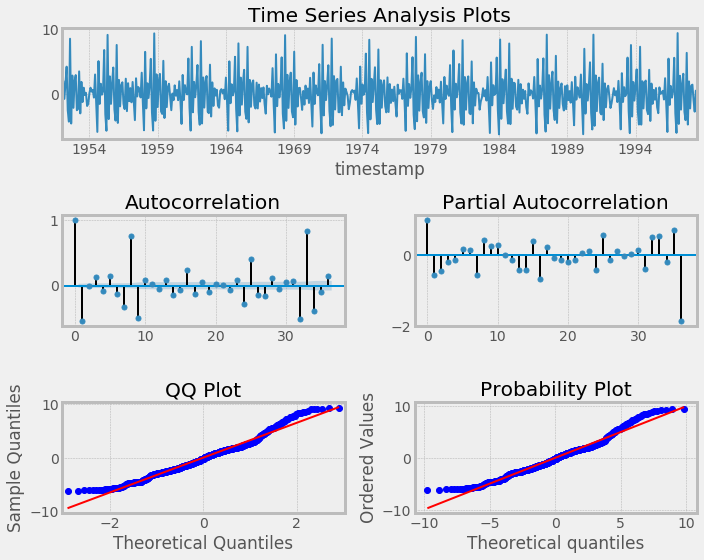

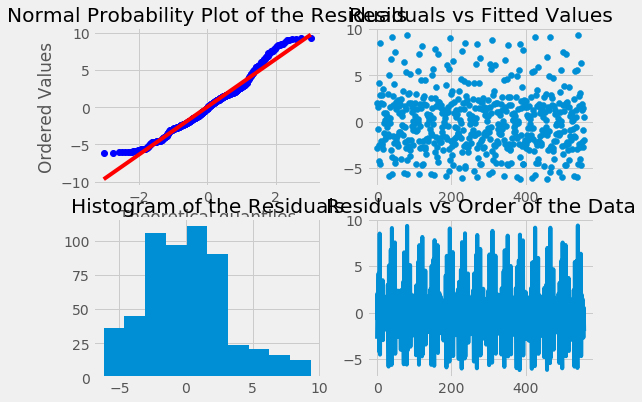

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [9.33741091e-038 1.46132278e-036 8.37915813e-038 1.20256327e-037
 1.24403224e-039 1.34956463e-040 5.09716768e-053 6.01473613e-121
 5.29385580e-149 5.21825672e-149 3.66715990e-148 1.74150026e-147
 1.43537685e-147 2.79414244e-149 5.80777606e-149 6.66942727e-155
 3.76328441e-156 1.09012566e-155 4.83818052e-156 2.53124129e-155]
PROBLEM!  There appears to be information left in the residuals
+------------+------------------------------------+
|   metric   |               value                |
+------------+------------------------------------+
|   label    | mex Fourier Series L_24 Regressors |
|    RMSE    |         3.235765971574008          |
| RMSE_pcent |        0.14238048810919057         |
+------------+------------------------------------+
+------------+--------------------

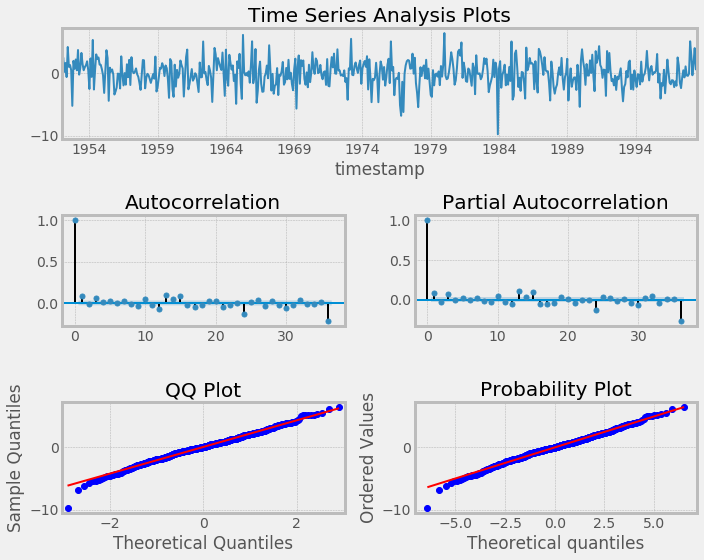

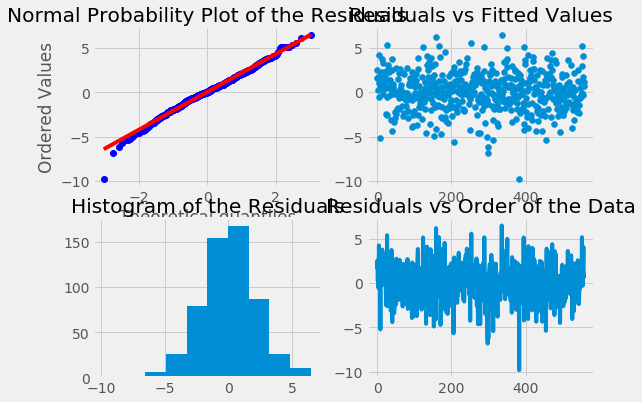

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.05274093 0.13889131 0.09992744 0.17666149 0.24694242 0.3526974
 0.4326845  0.53060233 0.55316005 0.53394039 0.59167423 0.44534558
 0.17345896 0.16634908 0.07791831 0.09648812 0.08884367 0.10718404
 0.1301464  0.15288184]
There does not appear to be information left in the residuals
+------------+-----------------------------------+
|   metric   |               value               |
+------------+-----------------------------------+
|   label    | mo Fourier Series L_24 Regressors |
|    RMSE    |         2.1346481971914235        |
| RMSE_pcent |        0.24098982379789793        |
+------------+-----------------------------------+
+------------+---------------------------------------+
|   metric   |                 value                 |
+------------+---------------------

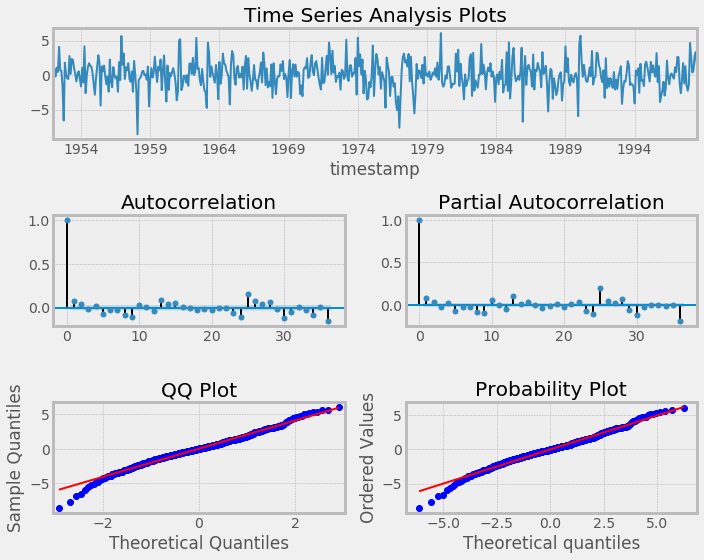

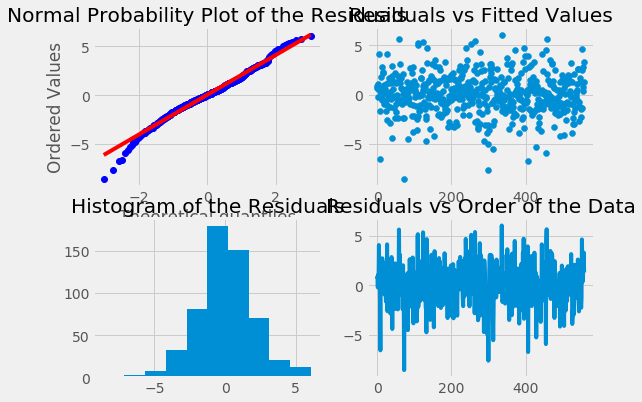

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.05130082 0.08144779 0.15963452 0.23873603 0.14767281 0.19310251
 0.23941583 0.10426655 0.01740569 0.02333745 0.03660202 0.04199182
 0.01415375 0.01672192 0.01590587 0.02358045 0.03382538 0.0436567
 0.05865778 0.07209599]
PROBLEM!  There appears to be information left in the residuals
+------------+-------------------------------------+
|   metric   |                value                |
+------------+-------------------------------------+
|   label    | ohio Fourier Series L_24 Regressors |
|    RMSE    |          2.0425584530755643         |
| RMSE_pcent |         0.18586637874372916         |
+------------+-------------------------------------+
+------------+-----------------------------------------+
|   metric   |                  value                  |
+------------+-

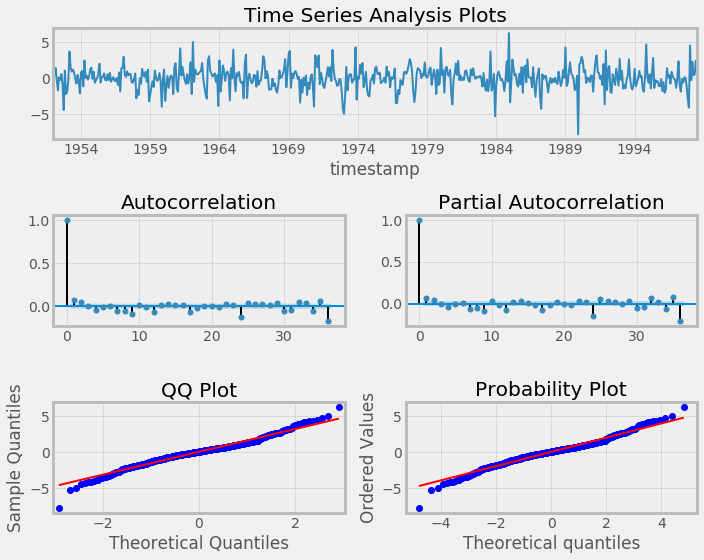

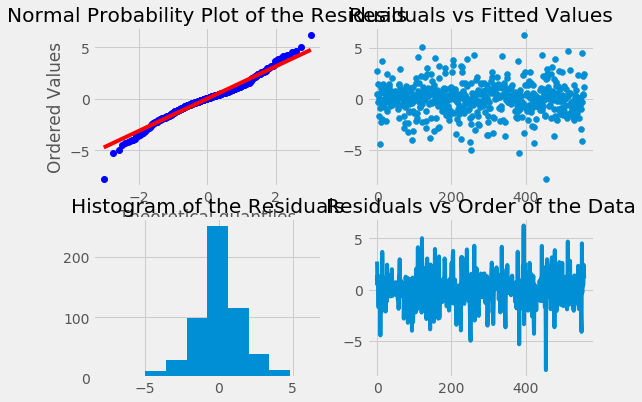

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.10255893 0.15403807 0.29043346 0.32232407 0.44939256 0.57785489
 0.45799229 0.39972969 0.13972221 0.18886487 0.24691383 0.19055149
 0.23880707 0.27175671 0.32245834 0.38621054 0.27911186 0.32071071
 0.3800982  0.4423749 ]
There does not appear to be information left in the residuals
+------------+------------------------------------+
|   metric   |               value                |
+------------+------------------------------------+
|   label    | rio Fourier Series L_24 Regressors |
|    RMSE    |         1.5847787925486074         |
| RMSE_pcent |        0.08390346177706519         |
+------------+------------------------------------+
+------------+----------------------------------------+
|   metric   |                 value                  |
+------------+-----------

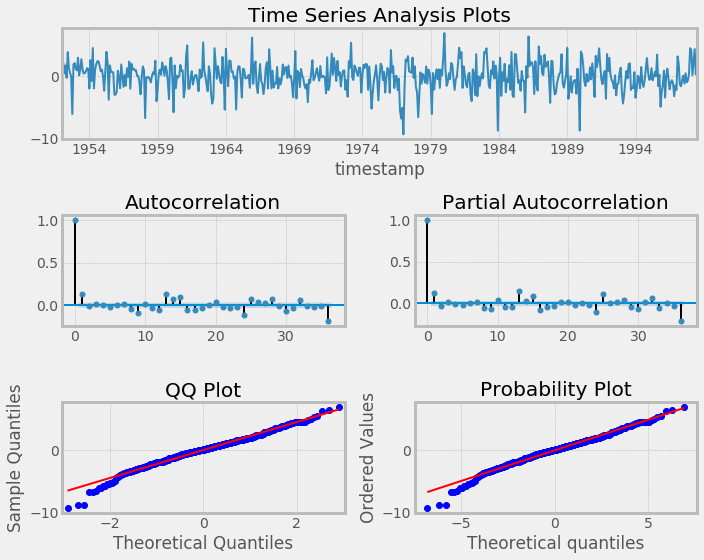

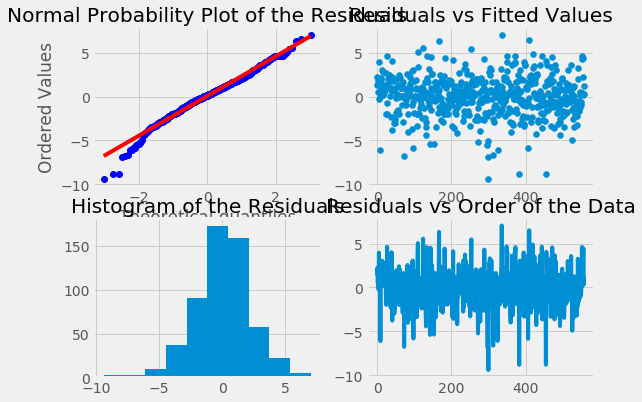

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.00223936 0.00915024 0.0234066  0.04989228 0.08465073 0.13849427
 0.19244465 0.18424195 0.07965309 0.11004746 0.12999949 0.10706656
 0.01053229 0.00662394 0.00214426 0.00219155 0.0022401  0.00286781
 0.00442748 0.00557322]
PROBLEM!  There appears to be information left in the residuals
+------------+-----------------------------------+
|   metric   |               value               |
+------------+-----------------------------------+
|   label    | up Fourier Series L_24 Regressors |
|    RMSE    |         2.271377024176791         |
| RMSE_pcent |        0.28761637773975807        |
+------------+-----------------------------------+
+------------+---------------------------------------+
|   metric   |                 value                 |
+------------+------------------

In [24]:
perf_in, perf_out, acorr_stat = regression.regional_auto_ols(data=df, show=True, diagnostics=False, lags=[1,6,12,24,36], fourier=True)

In [21]:
pd.DataFrame(perf_in).T

,label,RMSE,RMSE_pcent
ark_L24,ark Fourier Series L_24 Regressors,1.70725,0.123325
cali_L24,cali Fourier Series L_24 Regressors,1.45674,0.0820913
color_L24,color Fourier Series L_24 Regressors,1.66908,0.0960336
crb_L24,crb Fourier Series L_24 Regressors,1.40529,0.14589
east_L24,east Fourier Series L_24 Regressors,1.32774,0.0628489
glakes_L24,glakes Fourier Series L_24 Regressors,1.81292,0.264458
grb_L24,grb Fourier Series L_24 Regressors,1.62714,0.117361
gulf_L24,gulf Fourier Series L_24 Regressors,1.48787,0.0758469
low_L24,low Fourier Series L_24 Regressors,1.52082,0.0883945
mex_L24,mex Fourier Series L_24 Regressors,2.9791,0.131087


In [22]:
pd.DataFrame(perf_out).T

,label,RMSE,RMSE_pcent
ark_L24,ark Fourier Series L_24 OOS Regressors,1.6235,0.110283
cali_L24,cali Fourier Series L_24 OOS Regressors,1.40767,0.0772242
color_L24,color Fourier Series L_24 OOS Regressors,1.55203,0.0845558
crb_L24,crb Fourier Series L_24 OOS Regressors,1.30013,0.133223
east_L24,east Fourier Series L_24 OOS Regressors,1.49285,0.0691792
glakes_L24,glakes Fourier Series L_24 OOS Regressors,1.71918,0.233895
grb_L24,grb Fourier Series L_24 OOS Regressors,1.55945,0.106656
gulf_L24,gulf Fourier Series L_24 OOS Regressors,1.40846,0.0706914
low_L24,low Fourier Series L_24 OOS Regressors,1.42922,0.0813397
mex_L24,mex Fourier Series L_24 OOS Regressors,4.63337,0.206981


In [23]:
pd.DataFrame(acorr_stat,index=range(len(acorr_stat))).iloc[0,:]

ark_L24       2.043211
cali_L24      1.943576
color_L24     1.909822
crb_L24       1.831915
east_L24      1.987793
glakes_L24    2.013812
grb_L24       1.977861
gulf_L24      2.035252
low_L24       2.000895
mex_L24       2.953192
mo_L24        1.988590
ohio_L24      2.029225
rio_L24       2.028279
up_L24        2.004002
Name: 0, dtype: float64

#### Time Series Analysis of Raw Data

In [ ]:
testing.ts_plot(ark['min_temp'],lags=24,style='fivethirtyeight')

In [ ]:
lb, p_values = ljungbox(ark['min_temp'],
                        lags = 24)

p_values

- ADF stat indicates the time series is stationary
- PACF plot indicates some serial autocorrelation exists.
- significant p-vals of Ljung-Box test indiciates serial autocorrelation.